# Estimation

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
  - 1.1. [Load data](#toc1_1_)    
  - 1.2. [Find steady state](#toc1_2_)    
- 2. [Find IRFs](#toc2_)    
- 3. [Plot IRFs](#toc3_)    
- 4. [Estimate](#toc4_)    
- 5. [RANK](#toc5_)    
  - 5.1. [Comparison without re-estimation](#toc5_1_)    
  - 5.2. [Estimate](#toc5_2_)    
  - 5.3. [Comparison with re-estimation](#toc5_3_)    
- 6. [Test fixed exchange rate](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["NUMBA_PARFOR_MAX_TUPLE_SIZE"] = "200"

import numpy as np
import numba as nb
nb.set_num_threads(4)
import matplotlib.pyplot as plt   
import pandas as pd 

import figs
from IHANKModel import HANKModelClass, HANKModelClass_RA

**Settings:**

In [2]:
BASE_EST_HANK = 'initial_guess'
BASE_EST_RANK = 'HANK_est_par_best'
DO_SAVE_EST = True
EST_MAX_ITER_HANK = 0
EST_MAX_ITER_RANK = 0
DO_SE_HANK = False
DO_SE_RANK = False

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [3]:
model_HANK = HANKModelClass(name='HANK')

In [4]:
model_HANK.load_est_par(BASE_EST_HANK,do_print=True)

phi_I = 5.5788 [now: nan]
kappa_r = 0.2890 [now: nan]
NKslope__T = 0.0745 [now: nan]
NKslope_NT = 0.0679 [now: nan]
NKWslope__T = 0.0493 [now: nan]
NKWslope_NT = 0.0005 [now: nan]
pi_index = 0.6595 [now: nan]
piW_index = 0.8136 [now: 0.0000]
phi = 1.3421 [now: nan]
phi_back = 0.1411 [now: nan]
phi_N = 1.7901 [now: nan]
UIP_dev = 1.1098 [now: nan]
phi_X = 0.7825 [now: nan]
gamma = 2.9760 [now: nan]


### 1.1. <a id='toc1_1_'></a>[Load data](#toc0_)

In [5]:
import pickle
with open('LP_IRFs.pickle', 'rb') as handle:
    LP_IRFs = pickle.load(handle)

In [6]:
model_HANK.load_data()

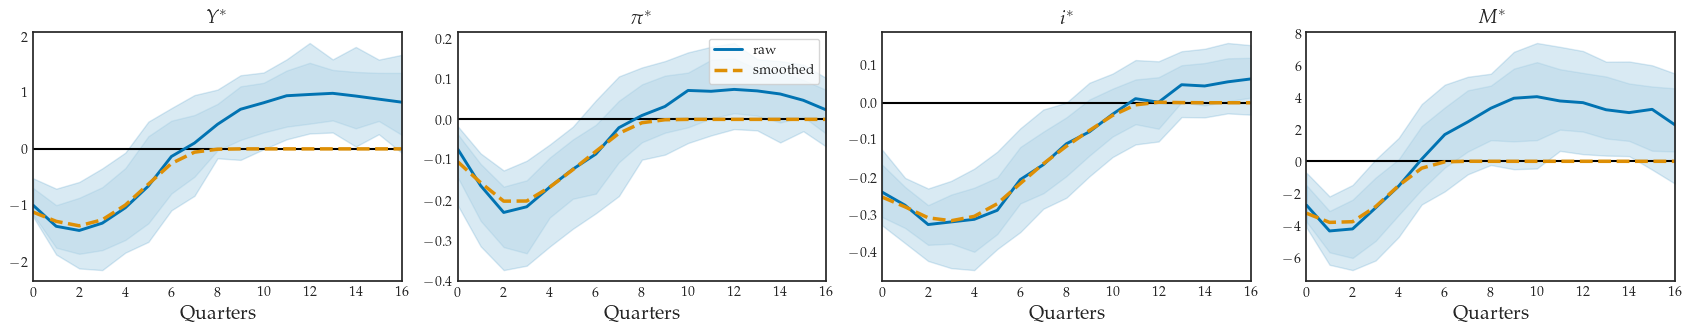

In [7]:
labels = {'Y_s':r'$Y^*$', 'piF_s' :r'$\pi^*$', 'iF_s':r'$i^*$', 'C_s':r'$M^*$'}

N_irf = len(model_HANK.data.LP_IRFS_large['IRF'].keys())
fig = plt.figure(figsize=(4.3*N_irf,3.6*1))
T_plot = len(model_HANK.data.LP_IRFS_large['IRF'][list(model_HANK.data.LP_IRFS_large['IRF'].keys())[0]])

for i, var in enumerate(model_HANK.data.LP_IRFS_large['IRF']):
    
    ax = fig.add_subplot(1,N_irf,i+1)
    ax.plot(np.arange(T_plot), np.zeros(T_plot), color='black', linestyle='-')
    
    irf = model_HANK.data.LP_IRFS_large['IRF'][var]
    ax.plot(np.arange(T_plot), irf[:T_plot]*100,  linestyle='-', linewidth=2.1,label='raw')

    HI = irf + model_HANK.data.LP_IRFS_large['HI'][var][:,0]*100
    LO = irf + model_HANK.data.LP_IRFS_large['LO'][var][:,0]*100
    ax.fill_between(np.arange(T_plot), LO[:T_plot], HI[:T_plot], alpha=0.15, color='C0')
    
    HI = irf + model_HANK.data.LP_IRFS_large['HI'][var][:,1]*100
    LO = irf + model_HANK.data.LP_IRFS_large['LO'][var][:,1]*100
    ax.fill_between(np.arange(T_plot), LO[:T_plot], HI[:T_plot], alpha=0.08, color='C0')
    
    ax.set_xlabel('Quarters', fontsize=14)  
    ax.set_title(labels[var], fontsize=14)
    ax.set_xlim([0, T_plot-1])

    # Smoothed 
    irf_smooth = model_HANK.data.LP_IRFS_large_smoothed[var]
    ax.plot(np.arange(T_plot), irf_smooth[:T_plot]*100, marker=None, markevery=4,  linestyle='--', linewidth=2.5, color='C1',label='smoothed')

    if i == 1: ax.legend(frameon=True)

fig.tight_layout(pad=1.6)
plt.show()
fig.savefig('plots/LP_IRFs_large_smoothed.pdf')

### 1.2. <a id='toc1_2_'></a>[Find steady state](#toc0_)

In [8]:
model_HANK.find_ss()

**Parameter determined in ss:**

In [9]:
par_set_in_ss = ['beta_mean','beta_delta','psi','alphaX', 'alphaK','FixedCost',
                'TFP','TFP_s','epsilon','epsilon_w','alphaF','alphaT', 'alpha_s',
                 'X_share_NT', 'X_share_T', 'X_expshare']

for parname in par_set_in_ss:

    value = model_HANK.par.__dict__[parname]

    if np.isscalar(value):
        print(f'{parname:15s} {value:.3f}')
    else:
        print(f'{parname:15s} {np.round(value,3)}')

beta_mean       0.975
beta_delta      0.020
psi             [0.312 1.303]
alphaX          [0.71 0.46]
alphaK          [0.345 0.333]
FixedCost       [0.372 0.282]
TFP             1.000
TFP_s           [7.353 1.744]
epsilon         [6. 6.]
epsilon_w       [6. 6.]
alphaF          0.423
alphaT          0.410
alpha_s         0.390
X_share_NT      [0.6 0.4]
X_share_T       [0.62  0.131 0.249]
X_expshare      [0.71 0.46]


## 2. <a id='toc2_'></a>[Find IRFs](#toc0_)

In [10]:
model_HANK.compute_jacs(skip_shocks=True,skip_hh=False)

In [11]:
model_HANK.find_transition_path_foreign_shock()

## 3. <a id='toc3_'></a>[Plot IRFs](#toc0_)

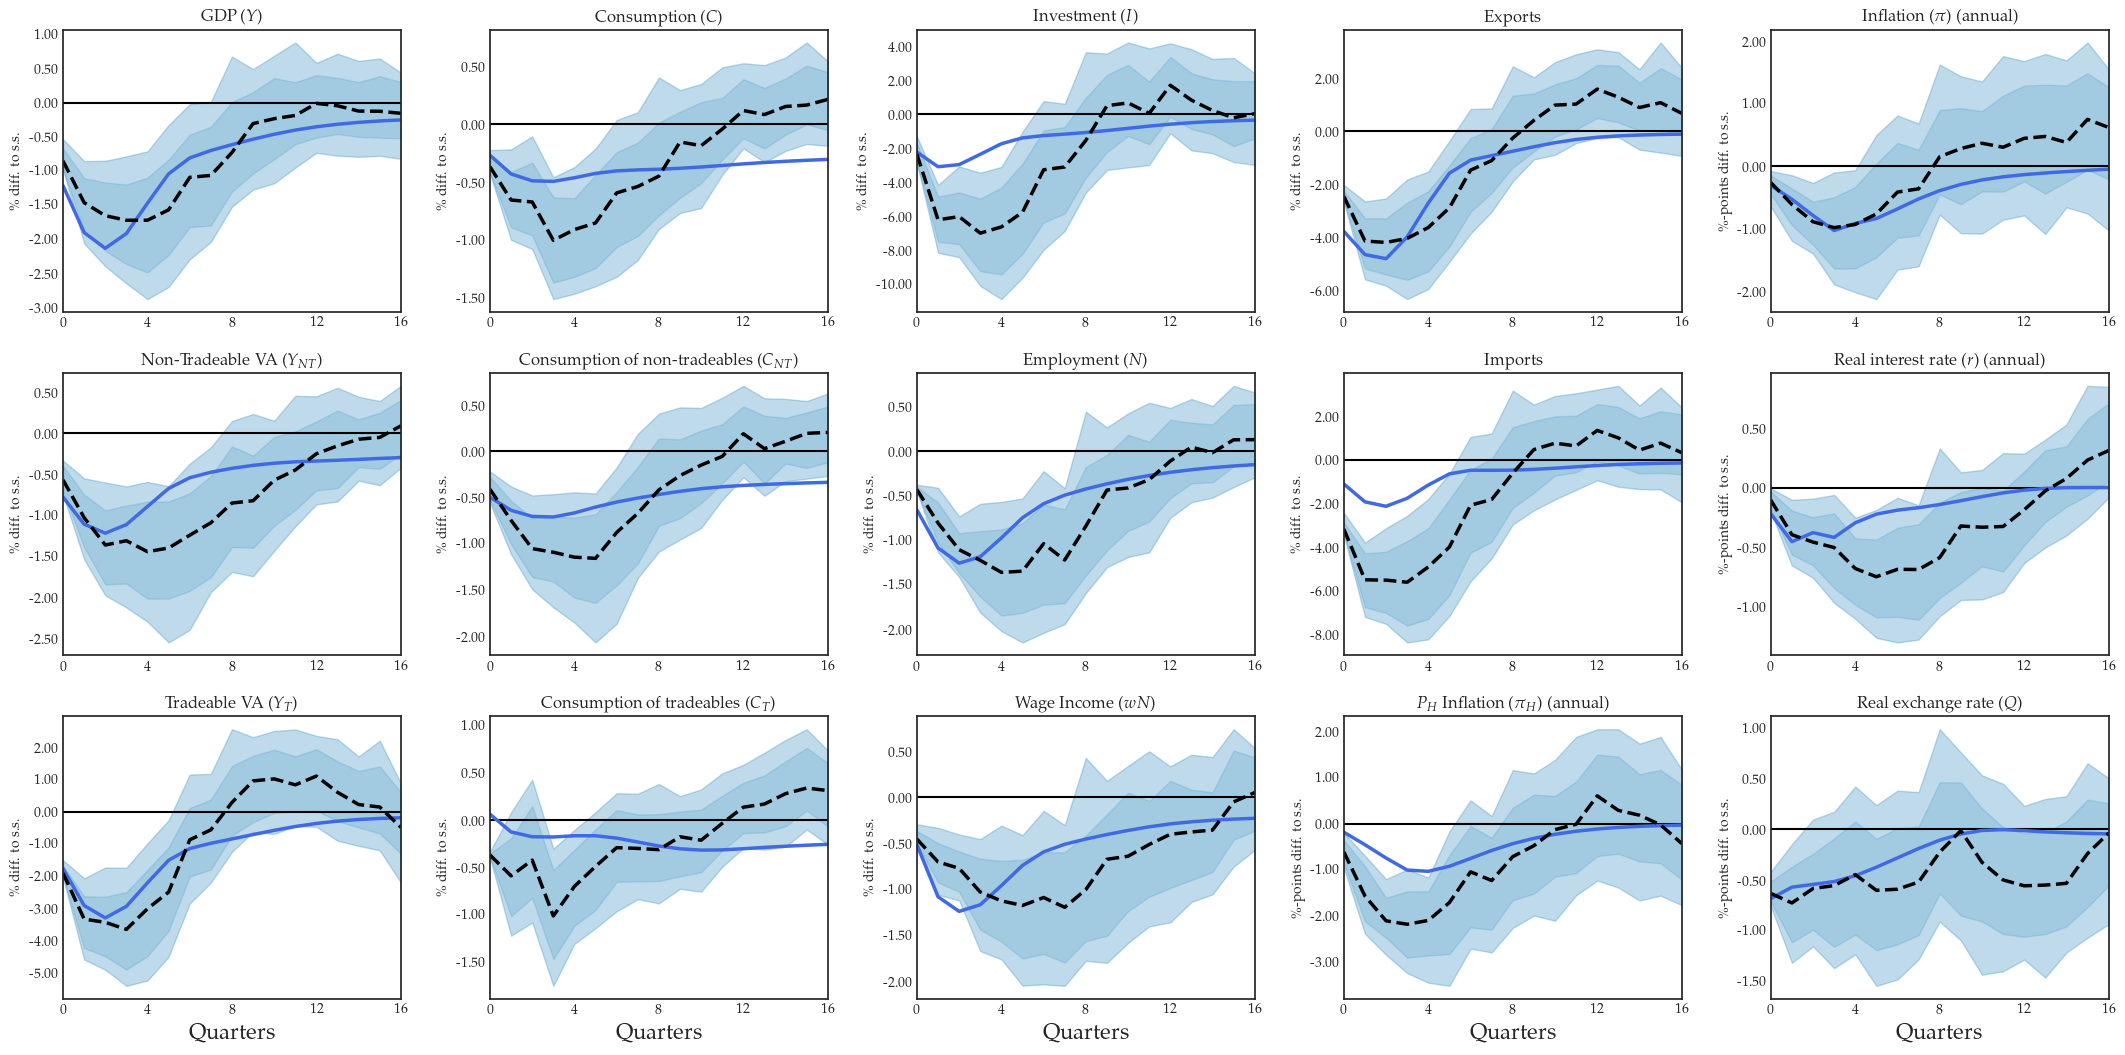

In [12]:
fig = figs.show_IRFs_vs_data([model_HANK],model_HANK.data)

## 4. <a id='toc4_'></a>[Estimate](#toc0_)

In [13]:
model_HANK.prepare_estimation(max_iter=EST_MAX_ITER_HANK,do_print=True)

,t,YT,YNT,I,N,labor_comp,Exports,r_ann,pi_ann,Q,piH_ann
0,0,3.010266,5.908461,3.812876,13.161206,21.477648,2.786364,24.423313,38.948804,94.733963,18.320919
1,1,1.653602,10.917547,0.617135,20.195053,20.143677,1.248003,31.237126,9.530273,7.574269,3.603846
2,2,1.113499,5.462757,0.380693,19.950063,18.205789,0.931053,23.652272,8.450550,5.965401,4.827960
3,3,0.718360,5.059232,0.225514,6.808680,7.055405,0.457186,11.423894,3.299169,4.192908,1.976112
4,4,0.582587,3.342723,0.161578,4.632283,4.935744,0.495089,13.235481,2.533745,3.452028,1.974513
5,5,0.558890,3.033877,0.138642,3.668193,3.544912,0.453915,8.504517,1.542583,3.106014,0.937608
6,6,0.758763,2.888364,0.158158,3.668686,3.308722,0.567128,7.682259,1.703098,3.194710,0.903575
7,7,0.890885,3.063258,0.169808,3.976819,3.278588,0.712552,7.479943,2.186585,3.908729,1.127109
8,8,0.812442,3.346442,0.164202,2.680602,2.312415,0.616245,5.552333,1.844571,3.272122,0.910797
9,9,1.096278,2.929295,0.230776,3.930297,2.598184,0.918888,8.405891,1.713622,2.973142,1.022502


In [14]:
# obj_val = model_HANK.est_obj(None) # for testing
# obj_val

In [15]:
model_HANK.estimate(do_se=DO_SE_HANK,do_print=True)

estimation stopped after 0 iterations

 NKslope__T = 0.0745
 NKslope_NT = 0.0679
 NKWslope__T = 0.0493
 NKWslope_NT = 0.0005
 pi_index = 0.6595
 piW_index = 0.8136
 phi = 1.3421
 phi_back = 0.1411
 phi_N = 1.7901
 phi_I = 5.5788
 kappa_r = 0.2890
 UIP_dev = 1.1098
 gamma = 2.9760
 phi_X = 0.7825


In [16]:
if DO_SAVE_EST: 
    model_HANK.save_est_par('HANK_est_par_best')
    model_HANK.save_x0s('HANK_x0s')

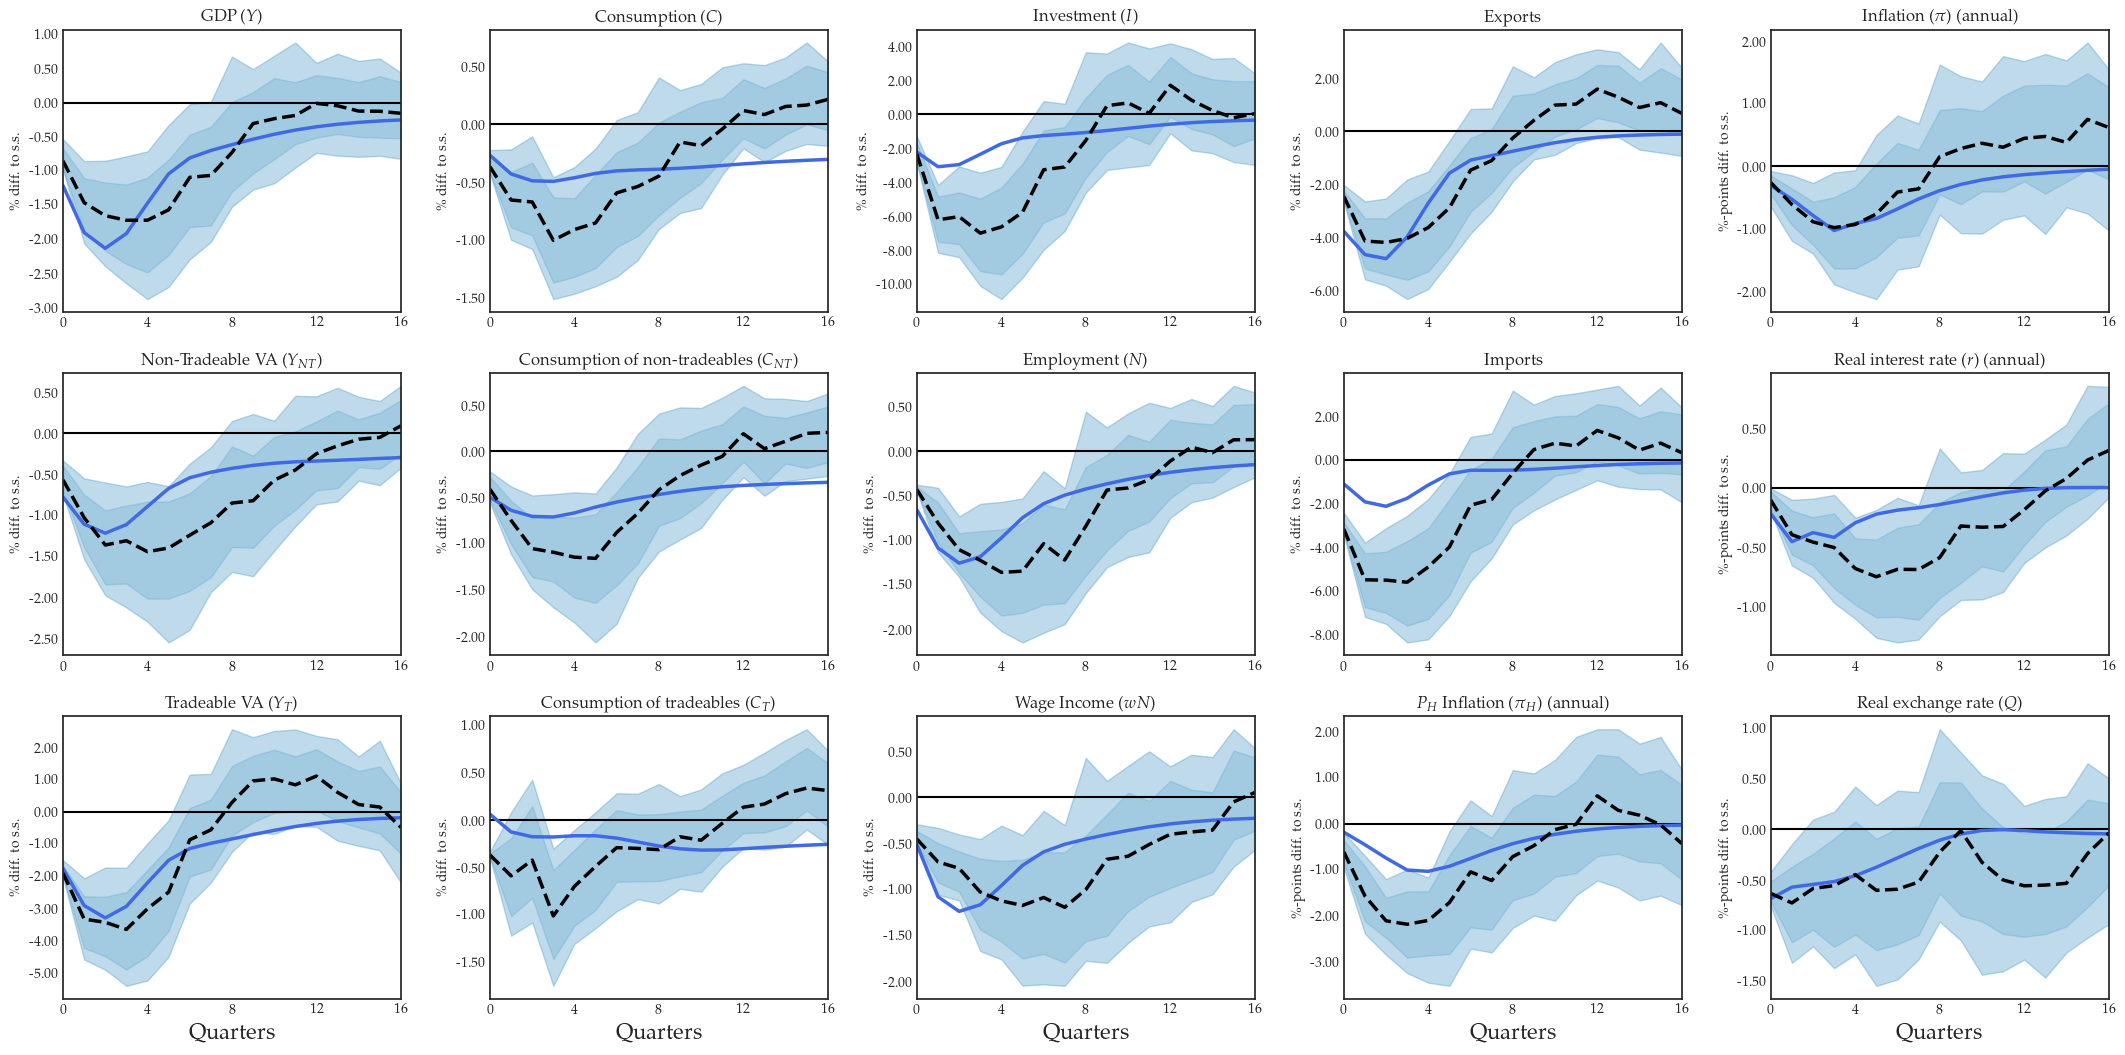

In [17]:
fig = figs.show_IRFs_vs_data([model_HANK],model_HANK.data,filename='est_HANK_fit')

Table with estimates

In [18]:
def write_table(model,do_se=False,precision=2):
    
    par_descs = {
        'NKslope__T' : [r'$\theta^P_T$', 'Rotemberg price parameter'], 
        'NKslope_NT' : [r'$\theta^P_{NT}$', 'Rotemberg price parameter'], 
        'NKWslope__T' : [r'$\theta^W_T$', 'Rotemberg wage parameter'], 
        'NKWslope_NT' : [r'$\theta^W_{NT}$', 'Rotemberg wage parameter'], 
        'pi_index' : [r'$\varpi$', 'Inflation indexation'], 
        'piW_index' : [r'$\varpi^W$', 'Wage indexation'], 
        'phi' : [r'$\phi^\pi$', 'Taylor coeff. on inflation'],
        'phi_back' : [r'$\rho^r$', 'Interest rate smoothing'],
        'phi_N' : [r'$\phi^{N}$', 'Employtment adj. cost'],
        'phi_I' : [r'$\phi^{I}$', 'Investment adj. cost'],
        'kappa_r' : [r'$\kappa^{I}$', 'Investment risk-premium elasticity'],
        'etaT' : [r'$\eta_{T,NT}$', r'Elasticity of sub. between $C_T$ and $C_{NT}$'],
        'eta' : [r'$\eta_{H,F}$', r'Elasticity of sub. between $C_F$ and $C_H$'],
        'UIP_dev' : [r'$\phi^{B^*}$', 'UIP deviation'],
        'phi_X' : [r'$\rho^{*}$', 'Dynamic export elasticity'],
        'gamma' : [r'$\eta^*$', 'Armington elasticity']
    }   
 
    # Read parameter estimates into dict
    best_x_dict = {}
    x = model.get_est_x(model.est.pardict)
    for i,parname in enumerate(model.est.pardict.keys()):
        best_x_dict[parname] = x[i]

    est_descs_ = {}
    for par in model.est.pardict.keys():
        est_descs_[par] = {}
        est_descs_[par]['Parameter'] =  par_descs[par][0]
        est_descs_[par]['Description'] =  par_descs[par][1]
        est_descs_[par]['Value'] =  best_x_dict[par]
        if do_se:
            SEs = model.est.se 
            est_descs_[par]['std. dev.'] =  f'({round(SEs[par],3)})'
        else:
            est_descs_[par]['std. dev.'] =  '-'

    
    df = pd.concat([
        pd.DataFrame(est_descs_)],axis=0)

    df = df.replace(np.NaN, '-')

    df_text = df.T.style.hide(axis='index').format(precision=precision)
    display(df_text)


    txt = df_text.to_latex()
    i = txt.find(r'$\theta^P_T')
    j = txt.find('\end{tabular}')
    with open(f'tables/estimation_tabel_main.txt','w') as text_file:
        text_file.write(txt[i:j])

write_table(model_HANK,do_se=DO_SE_HANK,precision=2)

Parameter,Description,Value,std. dev.
$\theta^P_T$,Rotemberg price parameter,0.07,-
$\theta^P_{NT}$,Rotemberg price parameter,0.07,-
$\theta^W_T$,Rotemberg wage parameter,0.05,-
$\theta^W_{NT}$,Rotemberg wage parameter,0.00,-
$\varpi$,Inflation indexation,0.66,-
$\varpi^W$,Wage indexation,0.81,-
$\phi^\pi$,Taylor coeff. on inflation,1.34,-
$\rho^r$,Interest rate smoothing,0.14,-
$\phi^{N}$,Employtment adj. cost,1.79,-
$\phi^{I}$,Investment adj. cost,5.58,-


## 5. <a id='toc5_'></a>[RANK](#toc0_)

In [19]:
model_RANK = HANKModelClass_RA(name='RANK',par={'HH_type':'RA-IM'})
model_RANK.load_data()
model_RANK.load_est_par(BASE_EST_RANK,do_print=True)

NKslope__T = 0.0745 [now: nan]
NKslope_NT = 0.0679 [now: nan]
NKWslope__T = 0.0493 [now: nan]
NKWslope_NT = 0.0005 [now: nan]
pi_index = 0.6595 [now: nan]
piW_index = 0.8136 [now: 0.0000]
phi = 1.3421 [now: nan]
phi_back = 0.1411 [now: nan]
phi_N = 1.7901 [now: nan]
phi_I = 5.5788 [now: nan]
kappa_r = 0.2890 [now: nan]
UIP_dev = 1.1098 [now: nan]
gamma = 2.9760 [now: nan]
phi_X = 0.7825 [now: nan]


In [20]:
model_RANK.find_ss()

In [21]:
model_RANK.compute_jacs(skip_shocks=True,skip_hh=True)
model_RANK.find_transition_path_foreign_shock()

### 5.1. <a id='toc5_1_'></a>[Comparison without re-estimation](#toc0_)

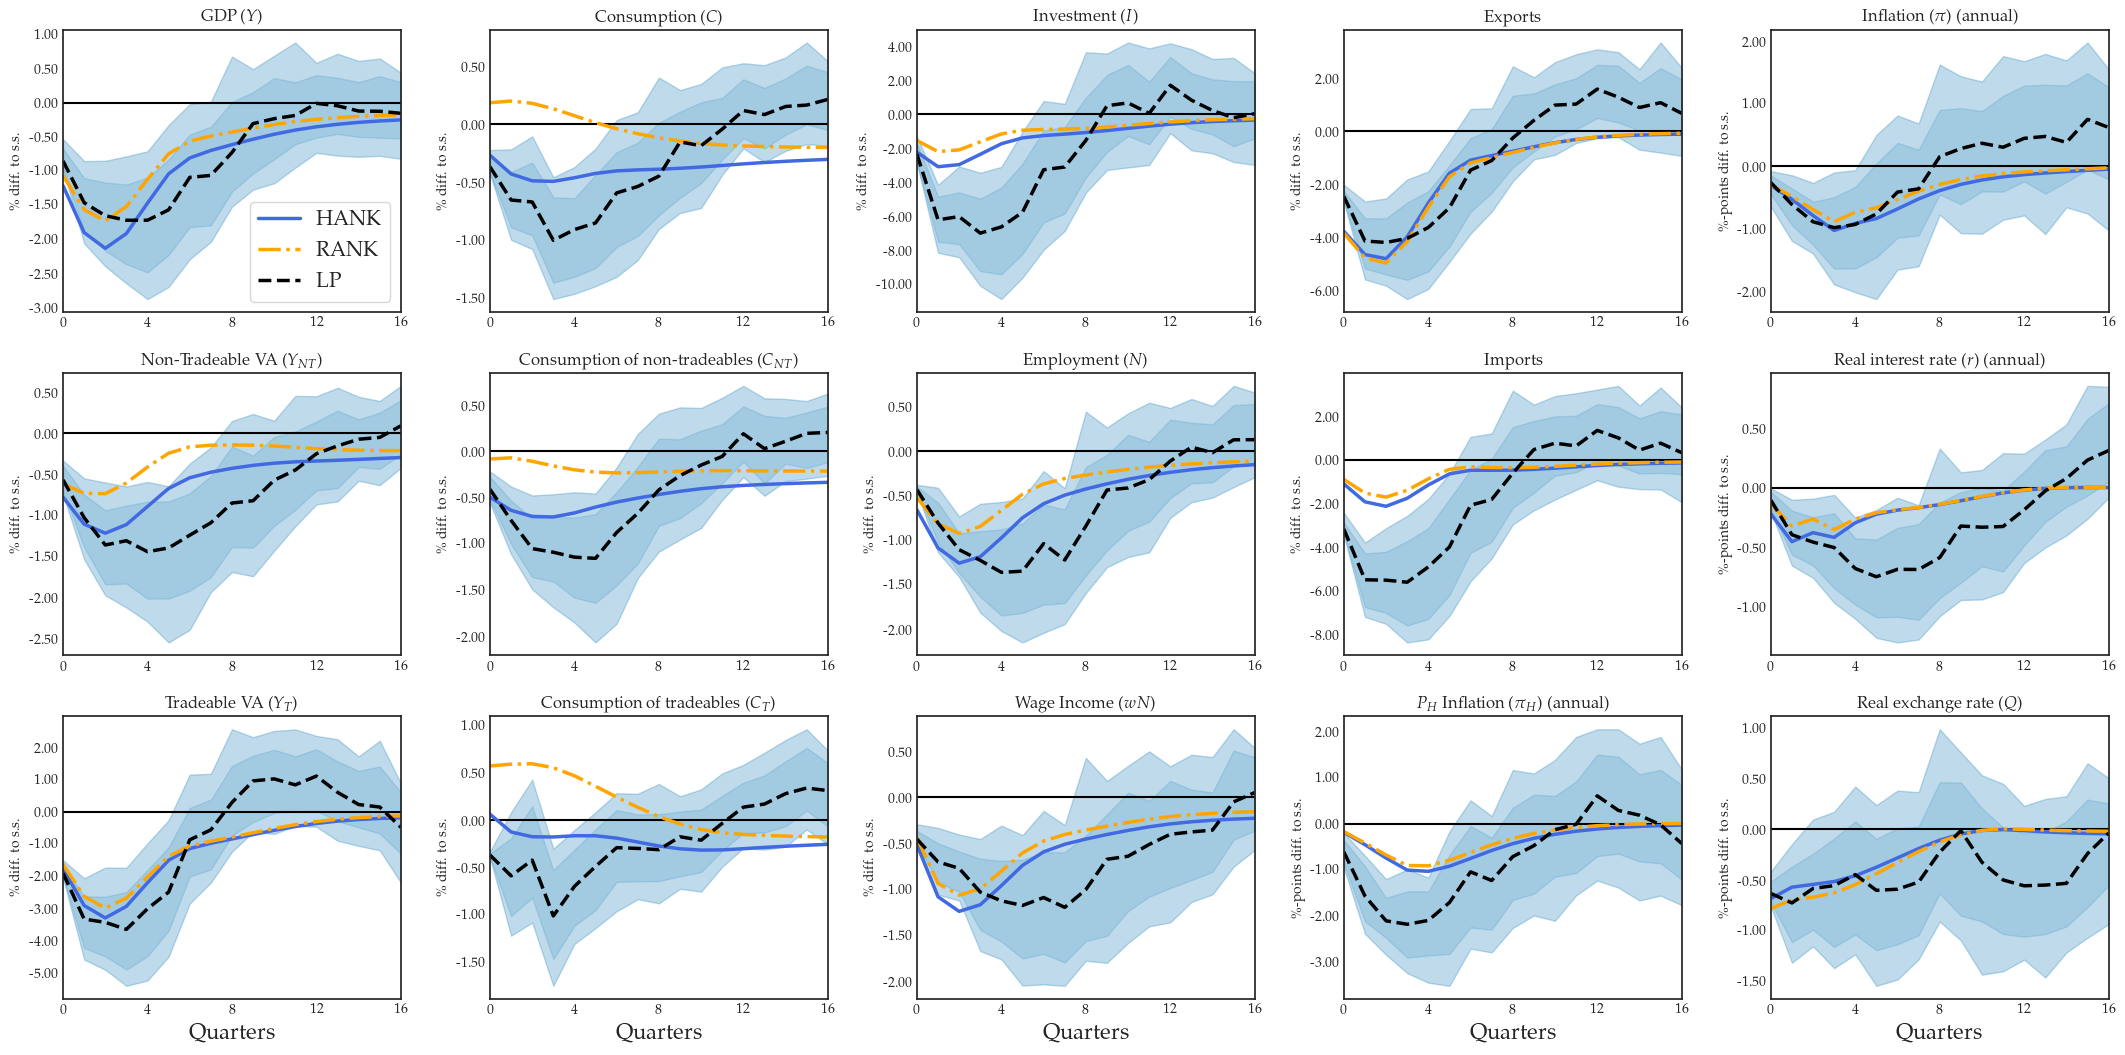

In [22]:
fig = figs.show_IRFs_vs_data([model_HANK,model_RANK],model_HANK.data,filename='est_HANK_RANK_no_reest_fit')

### 5.2. <a id='toc5_2_'></a>[Estimate](#toc0_)

In [23]:
model_RANK.prepare_estimation(max_iter=EST_MAX_ITER_RANK,do_print=False)
model_RANK.estimate(do_se=DO_SE_RANK,do_print=True)

estimation stopped after 0 iterations

 NKslope__T = 0.0745
 NKslope_NT = 0.0679
 NKWslope__T = 0.0493
 NKWslope_NT = 0.0005
 pi_index = 0.6595
 piW_index = 0.8136
 phi = 1.3421
 phi_back = 0.1411
 phi_N = 1.7901
 phi_I = 5.5788
 kappa_r = 0.2890
 UIP_dev = 1.1098
 gamma = 2.9760
 phi_X = 0.7825


In [24]:
if DO_SAVE_EST: model_RANK.save_est_par('RANK_est_par_best')

### 5.3. <a id='toc5_3_'></a>[Comparison with re-estimation](#toc0_)

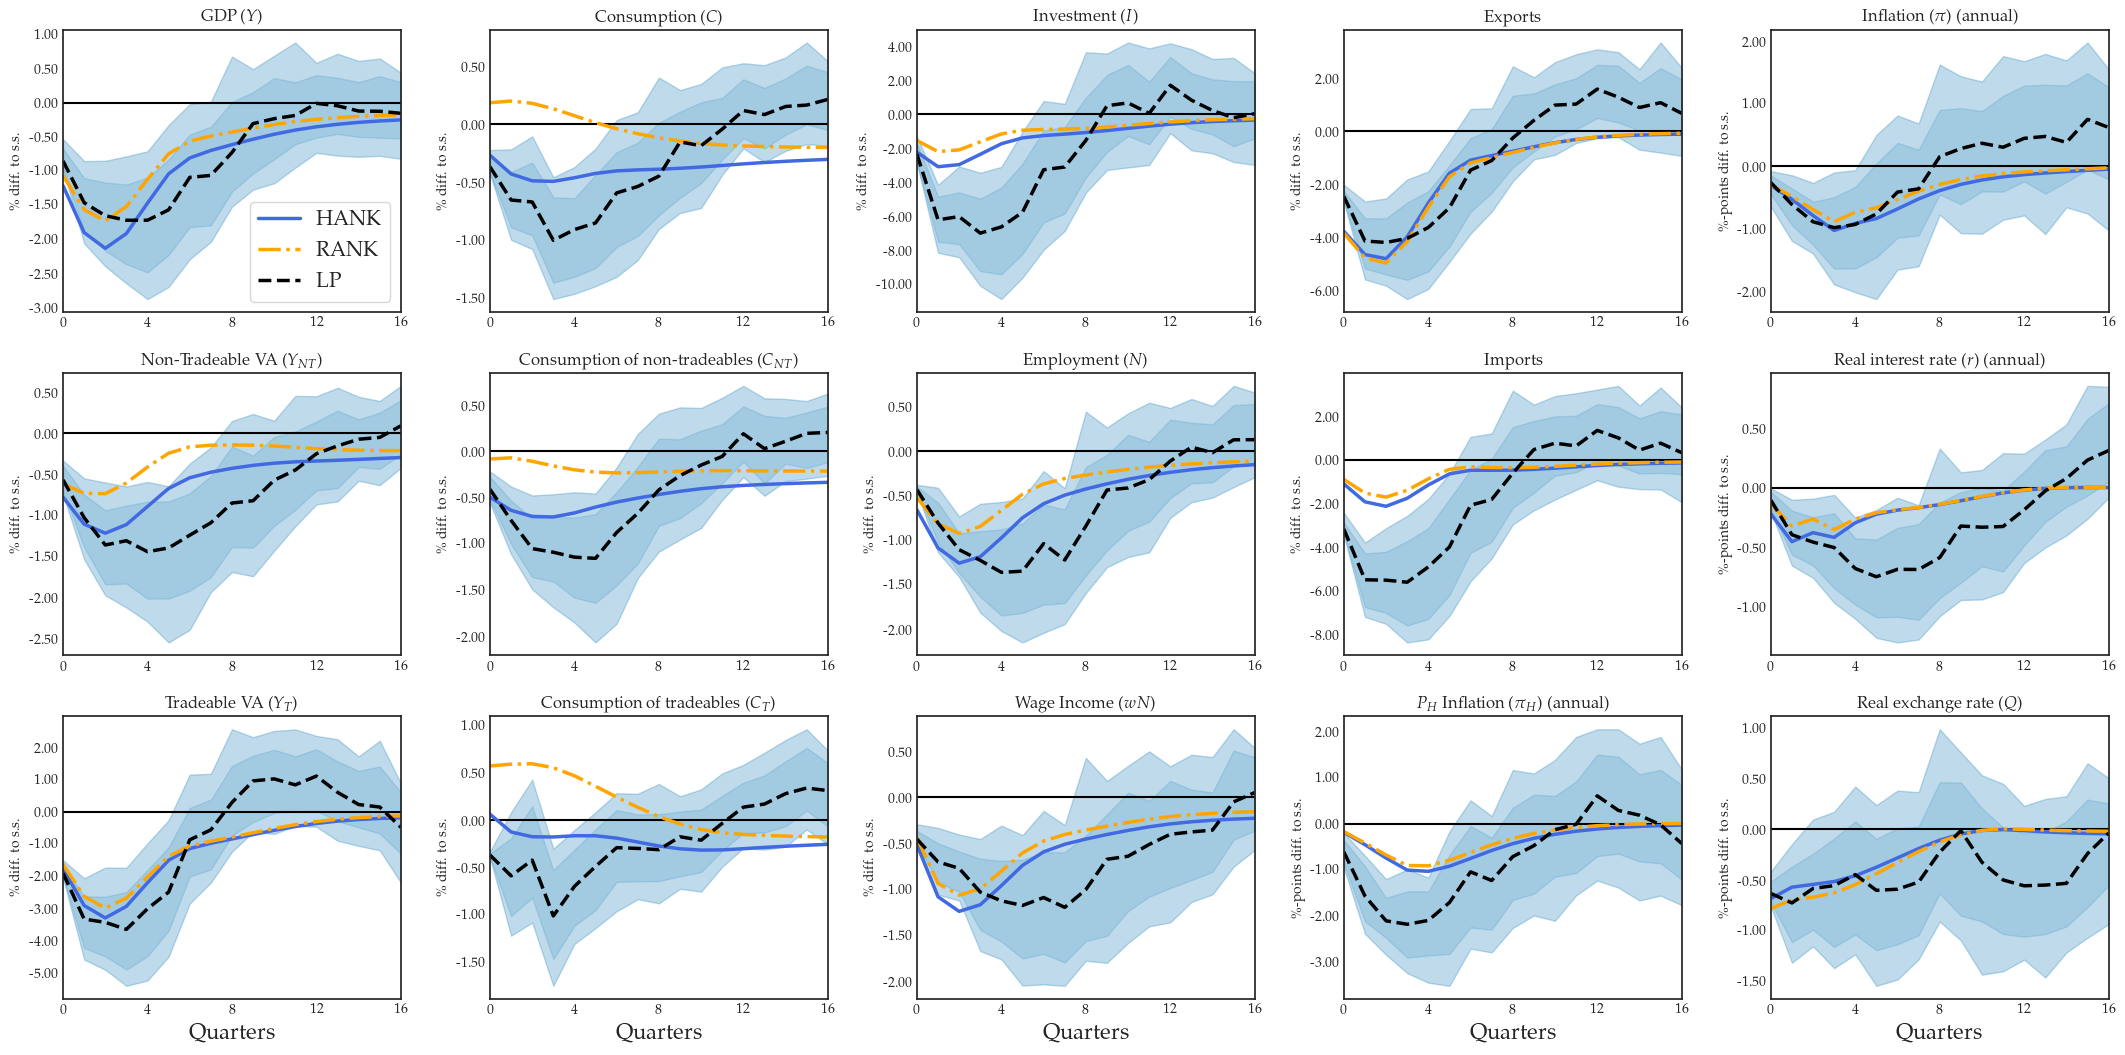

In [25]:
fig = figs.show_IRFs_vs_data([model_HANK,model_RANK],model_HANK.data,filename='est_HANK_RANK_fit')